<a href="https://colab.research.google.com/github/jdominguezm1300/physics-informed-neural-networks/blob/main/schrodinger_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pyDOE


In [37]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import optimize
from scipy.interpolate import griddata
from pyDOE import lhs
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import time
np.random.seed(1234)
tf.random.set_seed(1234)


In [38]:
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

class PhysicsInformedNN():

  def __init__(self,N0,N_b,N_f,layers,tf_epochs,tf_lr,tf_b1,tf_eps,nt_epochs,nt_lr,nt_ncorr,log_frequency, X_f,tb,ub,lb):
    #X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    self.X_lb =tf.convert_to_tensor(np.concatenate((0*tb + lb[0], tb), 1),dtype=tf.float64) # (lb[0], tb)
    self.X_ub =tf.convert_to_tensor(np.concatenate((0*tb + ub[0], tb), 1),dtype=tf.float64) # (ub[0], tb)
    self.x_f = tf.convert_to_tensor(X_f[:,0:1], dtype=tf.float64)
    self.t_f = tf.convert_to_tensor(X_f[:,1:2], dtype=tf.float64)
    self.nt_config = Struct()
    self.nt_config.learningRate = nt_lr
    self.nt_config.maxIter = nt_epochs
    self.nt_config.nCorrection = nt_ncorr
    self.nt_config.tolFun = 1.0 * np.finfo(float).eps
    self.tf_epochs = tf_epochs
    self.tf_optimizer = tf.keras.optimizers.Adam(learning_rate=tf_lr,beta_1=tf_b1,epsilon=tf_eps)
    tf.keras.backend.set_floatx('float64')
    self.model = tf.keras.Sequential()
    self.model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.model.add(tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:-1]:
      self.model.add(tf.keras.layers.Dense(width, activation=tf.nn.tanh,kernel_initializer="glorot_normal"))
      self.model.add(tf.keras.layers.Dense(layers[-1], activation=None,kernel_initializer="glorot_normal"))
    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    self.epoch_nt=tf_epochs
    self.loss_train_tf=[]
    self.loss_train_nt=[]
    self.start_time = time.time()
    self.prev_time = self.start_time
    self.frequency = log_frequency

    

  def net_uv(self,X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(x)
      tape.watch(t)
      Xtemp = tf.concat([x,t],axis=1)
      uv = self.model(Xtemp)
      u = uv[:,0:1]
      v = uv[:,1:2]
    u_x = tape.gradient(u, x)
    v_x = tape.gradient(v, x)
    del tape
    return u, v, u_x, v_x

  def net_f_uv(self):
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      X_f = tf.concat([self.x_f, self.t_f], axis=1)
      u, v, u_x, v_x = self.net_uv(X_f)
    u_t = tape.gradient(u, self.t_f)
    v_t = tape.gradient(v, self.t_f)
    u_xx = tape.gradient(u_x, self.x_f)
    v_xx = tape.gradient(v_x, self.x_f)
    del tape
    f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
    f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
    return f_u, f_v

  def loss(self,uv,uv_pred ):
    u0 = uv[:, 0:1]
    v0 = uv[:, 1:2]
    u0_pred = uv_pred[:, 0:1]
    v0_pred = uv_pred[:, 1:2]
    u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.X_lb)
    u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.X_ub)
    f_u_pred, f_v_pred = self.net_f_uv()
    mse_0 = tf.reduce_mean(tf.square(u0 - u0_pred)) + tf.reduce_mean(tf.square(v0 - v0_pred))
    mse_b = tf.reduce_mean(tf.square(u_lb_pred - u_ub_pred)) + tf.reduce_mean(tf.square(v_lb_pred - v_ub_pred)) + tf.reduce_mean(tf.square(u_x_lb_pred - u_x_ub_pred)) + tf.reduce_mean(tf.square(v_x_lb_pred - v_x_ub_pred))
    mse_f = tf.reduce_mean(tf.square(f_u_pred)) + tf.reduce_mean(tf.square(f_v_pred))
    loss_value=mse_0 + mse_b + mse_f
    return loss_value
  
  def predict(self, X_star):
    h_pred = self.model(X_star)
    u_pred = h_pred[:, 0:1]
    v_pred = h_pred[:, 1:2]
    return u_pred.numpy(), v_pred.numpy()

 
  def tf_optimization(self, X_u, u):
    print(f"-- Starting Adam optimization --")
    for epoch in range(self.tf_epochs):
      loss_value = self.tf_optimization_step(X_u, u)
      self.loss_train_tf.append([epoch,loss_value])
      self.log_train_epoch(epoch, loss_value,is_iter=False)

  def tf_optimization_step(self, X_u, u):
    loss_value, grads = self.grad(X_u, u)
    self.tf_optimizer.apply_gradients(zip(grads,self.model.trainable_variables ))
    return loss_value

  def grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.loss(u, self.model(X))
      grads = tape.gradient(loss_value, self.model.trainable_variables)
    return loss_value, grads


  def set_weights(self, w):
    for i, layer in enumerate(self.model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)


  def get_weights(self):
    w = []
    for layer in self.model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      self.sizes_w.append(len(weights))
      self.sizes_b.append(len(biases))
      w.extend(weights)
      w.extend(biases)
    w = tf.convert_to_tensor(w, dtype=tf.float64)
    return w

  def get_loss_and_flat_grad(self, X, u):
    def loss_and_flat_grad(w):
      grad_flat = []
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss_value = self.loss(u, self.model(X))
        self.loss_train_tf.append([self.epoch_nt,loss_value])
        self.epoch_nt+=1
        self.log_train_epoch(self.epoch_nt, loss_value,is_iter=False)
      grad = tape.gradient(loss_value, self.model.trainable_variables)
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat = tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    return loss_and_flat_grad
     
    
  def nt_optimization(self, X_u, u):
    print(f"-- Starting LBFGS optimization --")
    loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u)
    results=tfp.optimizer.lbfgs_minimize(
        loss_and_flat_grad,
        initial_position=self.get_weights(),
        num_correction_pairs=nt_ncorr,
        max_iterations=nt_epochs,
        f_relative_tolerance=1.0 * np.finfo(float).eps,
        tolerance=1.0 * np.finfo(float).eps,
        parallel_iterations=6)
    print('L-BFGS Results')
    print('Converged:', results.converged)
    print('Location of the minimum:', results.position)
    print('Number of iterations:', results.num_iterations)
    #self.nt_optimization_steps(loss_and_flat_grad)

  def log_train_epoch(self,epoch, loss, is_iter,custom=""):
    if epoch % self.frequency == 0:
      name = 'nt_epoch' if is_iter else 'tf_epoch'
      print(f"{name} = {epoch:6d}  " + f"elapsed = {self.get_elapsed()} " + f"(+{self.get_epoch_duration()})  " + f"loss = {loss:.4e}  " + custom)

  def get_epoch_duration(self):
        now = time.time()
        edur = datetime.fromtimestamp(now - self.prev_time) \
            .strftime("%S.%f")[:-5]
        self.prev_time = now
        return edur

  def get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")          


  def fit(self, X_u, u):
    print("\nTraining started")
    print("================")
    print(self.model.summary())
    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u,dtype=tf.float64)
    u =tf.convert_to_tensor(u,dtype=tf.float64)
    # Optimizing
    self.tf_optimization(X_u, u)
    self.nt_optimization(X_u, u)
    print("==================")
    print(f"Training finished (epochs {self.tf_epochs+self.nt_config.maxIter}): " + f"duration = {self.get_elapsed()}  "  )


In [39]:
N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]
tf_epochs=400
tf_lr=0.05
tf_b1=0.99
tf_eps=1e-1
nt_epochs=600
nt_lr=1.2
nt_ncorr=50
log_frequency=10


In [40]:
#Load Data
noise=0.0
data = scipy.io.loadmat('NLS.mat')

lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]    
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]
X_f = lb + (ub-lb)*lhs(2, N_f)


In [ ]:
pinn = PhysicsInformedNN(N0,N_b,N_f,layers,tf_epochs,tf_lr,tf_b1,tf_eps,nt_epochs,nt_lr,nt_ncorr,log_frequency, X_f,tb,ub,lb)
pinn.fit(x0, tf.concat([u0, v0], axis=1))

u_pred, v_pred = pinn.predict(X_star)
h_pred = np.sqrt(u_pred**2 + v_pred**2)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)

print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))


Training started
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_50 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_52 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_53 (Dense)             (None, 

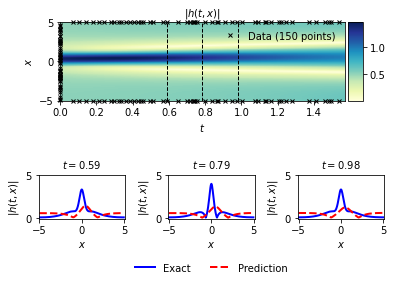

In [ ]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig = plt.figure()
ax = plt.axis('off')
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
ax.set_title('$|h(t,x)|$', fontsize = 10)
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5) 
ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)
plt.savefig('NLS')